# Machine learning algorithms to recognize handwritten double-digit images, overlaid with varying degrees of random (Gaussian distribution) pixel values.

Capstone Project, MLE Nanodegree program, Udacity.com

##Import the modules

In [1]:
import matplotlib.pyplot as plt
import random as rd
import numpy as np
import pandas as pd
 
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop, Adam

## Set the Variables

In [2]:
### Load raw MNIST data as tuples of numpy arrays
### Each tuple is: (examples of images, corresponding labels)
traintuple, testuple = tf.keras.datasets.mnist.load_data()

### Set values for data construction
image_size = (28,56) # base shape of a target image
model_kinds = ["miniNN", "CNN", "DNN", "comboNN", "ocNN"]
noise_levels = ["no", "high", "low", "var"]
training_keys = []
for nc in noise_levels:
    for k in model_kinds:
        training_keys.append((k, nc))

### Dict to translate noise level to description
describe_nl = {nc:d for (nc, d) in zip(noise_levels,
                    ["No noise", "High noise", "Low noise", "Variable noise"])} 

### Number of images to generate for each category
N_train = 100000    # for training
N_test = 20000      # for post-training evaluation
N_val = 10000       # to see progress while training

### Training hyperparameters (same for all models)
batch_size = 500
validation_batch_size = 100
epochs = 10
learning_rate = 0.001
input_layer = layers.Input(shape=(28, 56, 1))

11493376/11490434 [==============================] - 0s 0us/step


# Construct the Data

### Construction

In [3]:
############ Define Functions for data construction

def scale_array(arr):
    '''Scale an array of numbers.
        Params: numpy array of values to be scaled
        Returns: the same array with values scaled to (0,1)
    '''
    max = np.max(arr)
    min = np.min(arr)
    scaled = (arr - min)/(max - min)
    return scaled
print("Loaded function scale_array(arr)")

def get_noise(image, noise_condition="no"):
    ''' Add a normal disitribution of noise to an image
        Params: image: numpy array with values (0,1)
                noise_factor: one of "no", "low", "high", "var"
        Returns: noisy image array re-normalized to (0,1)
    '''
    # Dict to translate condition in terms of an image's standard deviation
    cond2num = {"no":0, 
                "low":0.5, 
                "high":1.5, 
                "var":1.5*rd.random()} # Different value each call, (0,1.3*std)
    noise_factor = np.std(image)*cond2num[noise_condition]
    noise = np.random.normal(np.mean(image), 
                             noise_factor, 
                             size=image.shape)
    # RE-normalize combined image back to (0,1)
    return scale_array(noise + image)
print("Loaded function get_noise(image, noise_condition)")

def doubleDigits(datatuple, nc="no"):
    ''' Merge two single-digit images into one double-digit image.
        Params: images: np.array with shape (N,28,28), values 0 to 255
                answers: np.array with shape (N,), values 0 to 9
                nf: "noise factor" (float) is multiples/fractions of image std
        Returns: noisy double-digit image as a numpy array with shape (28,56),
                with values normed to (0.0, 1.0); 
                and the corresponding label, with values now 0 to 99
    '''
    (images,answers)=datatuple  # = (x, y)
    
    # Randomly select left and right single digit images
    # with values 0 to 9, from the same raw training or test data set
    left_index = rd.randrange(0, len(answers))   
    right_index = rd.randrange(0, len(answers))
    # Calculate double digit label 0 to 99
    answer = answers[left_index]*10 + answers[right_index]
    
    # Have to scale them here because they have
    # different distributions of pixel values
    left_scaled = scale_array(images[left_index])
    right_scaled = scale_array(images[right_index])

    # Make background array with shape (28,56)
    image = np.zeros(image_size)
    # Group digits closer to middle of new image
    width = image_size[1]
    half_width = width//2  
    # Shift left digit to the right
    image[:,8:half_width+4] = left_scaled[:,4:half_width]
    # Shift right digit to the left
    image[:,half_width-4:width-8] += right_scaled[:,0:half_width-4]
    # Have to clip in case some bright pixels overlap
    image = image.clip(0,1)
    # Add noise to the new double digit image
    # get_noise() will overlay a Normal distribution of
    # random pixel values centered on the mean of pixel values
    # in the image, and with "noise_factor" as the width of the
    # distribution in multiples or fractions of the 
    # standard deviation of the pixel values in the image:
    # 0 = no distortion, +inf = uniform distribution  
    # Rescale pixel values to (0,1) (again!)
    image = get_noise(image, nc)  
    return image, int(answer)              
print("Loaded function doubleDigits(datatuple, nc=no)")

def getDoubleDigits(datatuple, how_many=1, nc="no"):
    ''' Aggregate a specified number of two-digit images, with or without noise
        Params: image array of size (N, (image size)),
                answers array of size (N,)
        Returns: a single 28x56 double-digit image and
                 the corresponding array of int labels
    '''
    yy = np.zeros((how_many,),dtype=int)
    xx = np.zeros((how_many, image_size[0], image_size[1]))
    for i in range(how_many):
        dd, ans = doubleDigits(datatuple, nc)
        yy[i] = ans
        xx[i] = dd
    return (xx, yy) # (new image, corresponding label)
print("Loaded function getDoubleDigits(datatuple,how_many=1,nc=no)")

Loaded function scale_array(arr)
Loaded function get_noise(image, noise_condition)
Loaded function doubleDigits(datatuple, nc=no)
Loaded function getDoubleDigits(datatuple,how_many=1,nc=no)


In [4]:
### Generate sets of double-digit images for training, testing, and validation
### One set for each noise level: no, low, high, and var

train_data = {} # {noise level : tuple of training data (x,y)}
val_data = {}   # {noise level : val data (x,y)}
test_data = {}  # {noise level : test data (x,y)}

for nc in noise_levels:
    print ("Noise level:", describe_nl[nc])
    if nc is "no":
        ### Make a set of training, validation, and test images
        ### First set with no noise added as a baseline
        x_train, y_train = getDoubleDigits(traintuple, N_train, nc=nc)
        print("Made",N_train,"new double-digit images to train on.")
        # Test and validation sets constructed from test images in MNIST
        x_val, y_val = getDoubleDigits(testuple, N_val, nc=nc)
        print("Made",N_val,"new double-digit images to validate on.")
        x_test, y_test = getDoubleDigits(testuple, N_test, nc=nc)
        print("Made",N_test,"new double-digit images to test on.")
    else:
        # Add noise to the baseline "no noise" set 
        x0_train, y_train = train_data["no"]
        x0_val, y_val = val_data["no"]
        x0_test, y_test = test_data["no"]
        x_train = np.array([get_noise(img.reshape(image_size),nc) for img in x0_train])
        print("Added",describe_nl[nc],"to",N_train,"double-digit images for training.")
        x_val = np.array([get_noise(img.reshape(image_size),nc) for img in x0_val])
        print("Added",describe_nl[nc],"to",N_val,"double-digit images for validation.")
        x_test = np.array([get_noise(img.reshape(image_size),nc) for img in x0_test])
        print("Added",describe_nl[nc],"to",N_test,"double-digit images for evaluation.")        
    
    ### Add a black-and-white channel dimension
    x_train = x_train[..., np.newaxis].astype("float32")
    x_val = x_val[..., np.newaxis].astype("float32")
    x_test = x_test[..., np.newaxis].astype("float32")

    ### Update dict for converting from noiselevel to dataset
    train_data.update({nc:(x_train, y_train)})
    val_data.update({nc:(x_val, y_val)}) 
    test_data.update({nc:(x_test, y_test)})


Noise level: No noise
Made 100000 new double-digit images to train on.
Made 10000 new double-digit images to validate on.
Made 20000 new double-digit images to test on.
Noise level: High noise
Added High noise to 100000 double-digit images for training.
Added High noise to 10000 double-digit images for validation.
Added High noise to 20000 double-digit images for evaluation.
Noise level: Low noise
Added Low noise to 100000 double-digit images for training.
Added Low noise to 10000 double-digit images for validation.
Added Low noise to 20000 double-digit images for evaluation.
Noise level: Variable noise
Added Variable noise to 100000 double-digit images for training.
Added Variable noise to 10000 double-digit images for validation.
Added Variable noise to 20000 double-digit images for evaluation.


### Sample sets

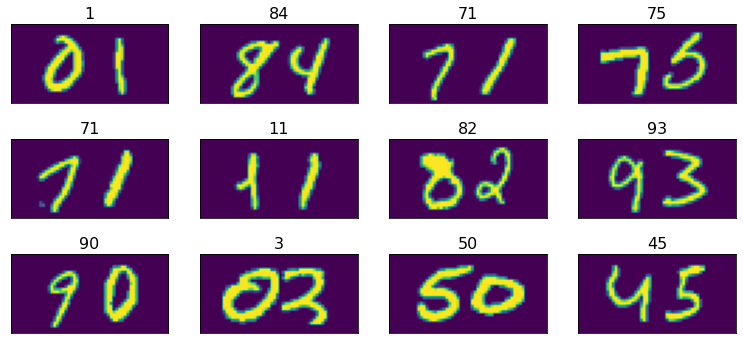

In [5]:
### Sample of 10 no-noise double-digits
images, labels = getDoubleDigits(traintuple, 
                                 nc="no", 
                                 how_many=12)
fig,arr = plt.subplots(3,4,True,True,)
fig=fig.set_size_inches(13,6)
arr=arr.reshape(12,)
for i in range(arr.shape[0]):   
    arr[i].set_title(labels[i], fontsize=16)
    arr[i].imshow(images[i],cmap='viridis')
lox,lax=plt.xticks([])
loy,lay=plt.yticks([])


Answers: [55  0 41 68 14]


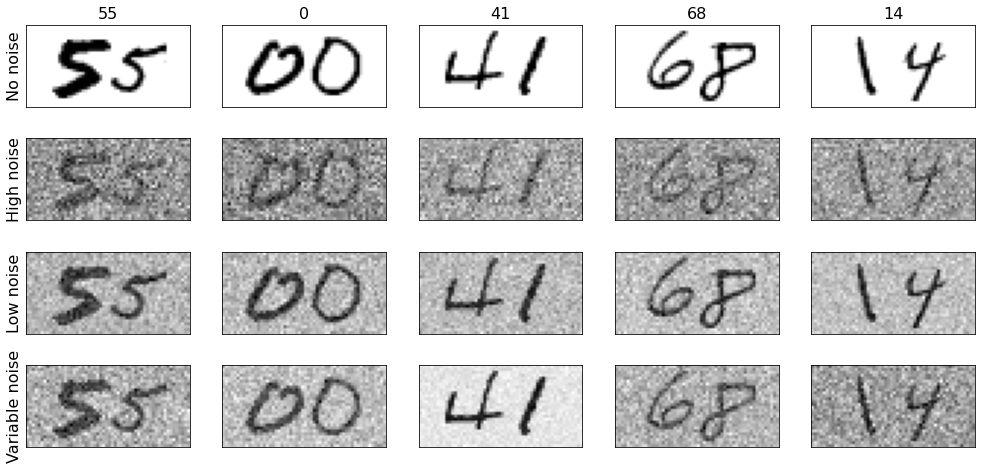

In [6]:
### Show a sample of five images for each noise level
ncols = 5
x0, y0 = getDoubleDigits(traintuple, nc="no", how_many=ncols)
print('Answers:',y0) 

f,a = plt.subplots(4,5,True,True,)
f=f.set_size_inches(17,8)
a=a.reshape(20,)
for i, nl in enumerate(noise_levels):
    if nl == "no": 
        x = x0
    else: 
        x = np.array([get_noise(img.reshape(image_size),nl) for img in x0])    
    for j in range(5): 
        if j==0: a[5*i].set_ylabel(describe_nl[nl],fontsize=16)
        if i==0: a[j].set_title(y0[j],fontsize=16)
        a[5*i+j].imshow(x[j],cmap='binary')
lox,lax=plt.xticks([])
loy,lay=plt.yticks([])

### Data distribution

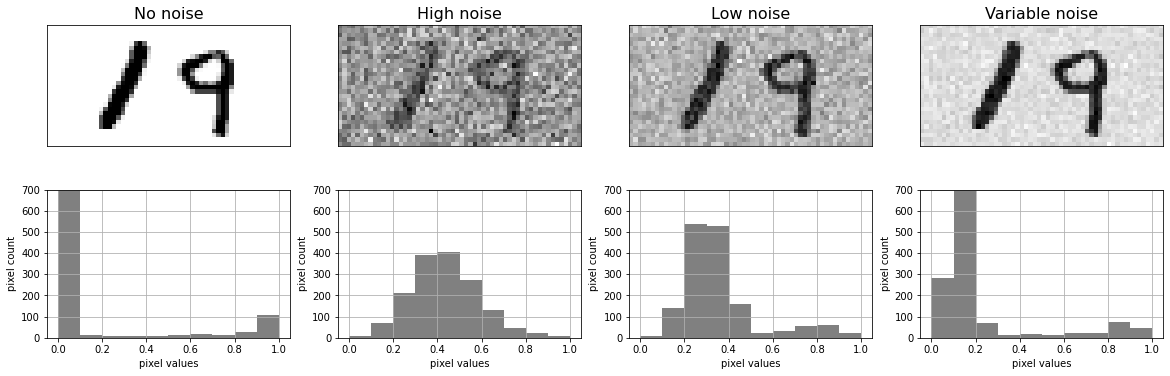

In [9]:
# Display the distribution of pixel values for each noise level on a random image
idx = rd.randrange(val_data["no"][0].shape[0])
f = plt.figure(figsize=(20,6))
histax = f.subplots(2,4)
for i, nl in enumerate(noise_levels):
    xt = pd.DataFrame(val_data[nl][0].reshape(-1,28*56)).iloc[idx]
    hix = histax[0,i]
    hix.set_xticks([])
    hix.set_yticks([])
    hix.set_title(describe_nl[nl], fontsize=16)
    hix.imshow(np.array(xt).reshape(image_size), cmap='gray_r')
    hax = histax[1,i]
    barx = xt.hist(ax=hax, color='gray')
    barx.set_ylabel("pixel count")
    barx.set_xlabel("pixel values")
    barx.set_ylim(0,700)

# Build and Train the Models

In [10]:
### Define functions for building, training, compiling and evaluating models

def build_model(key, verbose=True):
    '''Builds a model of each kind, for each noise level
        params: a tuple of "model kind" and "noise level"
                verbose turns on printed reports
        returns: a model of the specified kind, to be
                 dedicated to noise of the specified level
    '''
    (model_kind, noise) = key
    ## Input layer: same for for all models
    input_layer = layers.Input(shape=(image_size[0], image_size[1], 1))
        
    if "miniNN" in model_kind:
        ########### Build model miniNN as a minimal, baseline model 
        x = layers.Flatten()(input_layer)#
        output_layer = layers.Dense(100, activation='softmax')(x)
        miniNN = Model(input_layer, output_layer, name="miniNN_"+noise)
        if verbose: print ("built", miniNN.name)
        return miniNN

    elif "CNN" in model_kind:
        ########### Build model CNN: typical convolutional neural network
        x = layers.Conv2D(20, 3, activation='relu')(input_layer)#, padding='same'
        x = layers.MaxPooling2D(2)(x)
        x = layers.Conv2D(30, 2, activation='relu')(x) 
        x = layers.AveragePooling2D(2)(x)
        x = layers.Flatten()(x)
        output_layer = layers.Dense(100, activation='softmax')(x)
        CNN = Model(input_layer, output_layer, name="CNN_"+noise)
        if verbose: print ("built", CNN.name)
        return CNN
    
    elif "DNN" in model_kind:
        ########### Build model DNN, a densely connected NN with 4 layers
        x = layers.Flatten()(input_layer)
        x = layers.Dropout(0.1)(x)
        x = layers.Dense(555, activation='relu')(x)
        x = layers.Dropout(0.1)(x)
        x = layers.Dense(222, activation='relu')(x)
        output_layer = layers.Dense(100, activation='softmax')(x)
        DNN = Model(input_layer, output_layer, name="DNN_"+noise)
        if verbose: print ("built", DNN.name)
        return DNN

    elif "comboNN" in model_kind:
        ########### Build model comboNN, a hybrid of both convolutional and dense layers 
        x = layers.Conv2D(20, 3, activation='relu')(input_layer)
        x = layers.AveragePooling2D(2)(x)
        x = layers.Flatten()(x)
        x = layers.Dense(720, activation='relu')(x)
        x = layers.Dropout(0.2)(x)
        output_layer = layers.Dense(100, activation='softmax')(x)
        comboNN = Model(input_layer, output_layer, name="comboNN_"+noise)
        if verbose: print ("built", comboNN.name)
        return comboNN

    elif "ocNN" in model_kind:
        ########### Build "overcomplicated" model ocNN, of superfluous complexity 
        x = layers.Flatten()(input_layer)
        x = layers.Dense(800, activation='relu')(x)

        x1 = layers.Dropout(0.3)(x)
        x1 = layers.Dense(500, activation='relu')(x1) 
        x1 = layers.Dropout(0.25)(x1)

        x2 = layers.Dropout(0.1)(x)
        x2 = layers.Dense(300, activation='relu')(x2) 

        y1 = layers.Conv2D(25, 5, activation='relu')(input_layer)
        y1 = layers.MaxPooling2D(2)(y1)
        y1 = layers.Conv2D(25, 3, activation='relu')(y1) 
        y1 = layers.AveragePooling2D(2)(y1)
        y1 = layers.Conv2D(25, 2, activation='relu', padding='same')(y1)
        y1 = layers.Flatten()(y1)
        y1 = layers.Dropout(0.2)(y1)
        
        y2 = layers.Conv2D(22, 3, activation='relu')(input_layer) 
        y2 = layers.Conv2D(33, 2, activation='relu', padding='same')(y2)
        y2 = layers.MaxPooling2D(2)(y2)
        y2 = layers.Conv2D(11, 2, activation='relu')(y2)
        y2 = layers.Flatten()(y2)
        
        z1 = layers.Concatenate()([x1,y1])
        z1 = layers.Dropout(0.2)(z1)

        z2 = layers.Concatenate()([x2,y2])
        z2 = layers.Dropout(0.1)(z2)

        z = layers.Dropout(0.4)(x)
        z = layers.Concatenate()([z,z1,z2])
        z = layers.Dropout(0.3)(z)
        z = layers.Dense(2222,activation="relu")(z)
        z = layers.Dropout(0.2)(z)
        z = layers.Dense(222,activation="relu")(z)
        
        logits_layer = layers.Dense(100, activation='softmax')(z) 
        ocNN = Model(input_layer, logits_layer, name="ocNN_"+noise)
        if verbose: print ("built", ocNN.name)
        return ocNN

    else:
        print ("Could not find that kind of model.")
        return None
print("loaded function build_model((model_kind, noise_level))")

## Same training loop for all models
def train(model, traintuple, valtuple, epochs=epochs):
    '''Train a model on the given sets of data
        Params: the given model,
                the train data as a tuple of x,y,
                the test data as a tuple of x,y
        Returns: a dictionary of metric values after each epoch of training
    '''
    (x_train, y_train) = traintuple
    (x_val, y_val) = valtuple

    history = model.fit(x=x_train,
                        y=y_train,
                        batch_size=batch_size,
                        validation_data=valtuple,
                        validation_batch_size=validation_batch_size,
                        epochs=epochs,  
                        verbose=1)   
    return history.history
print("loaded function train(model, traintuple, testuple, epochs=epochs)")

## All models are compiled the same
def compile_model(model):    
    model.compile(  loss="sparse_categorical_crossentropy",
                    optimizer=RMSprop(lr=learning_rate),                    
                    metrics=['acc'])
    print ("Compiled model", model.name)
print("loaded function compile_model(model)")

loaded function build_model((model_kind, noise_level))
loaded function train(model, traintuple, testuple, epochs=epochs)
loaded function compile_model(model)


In [11]:
### Build all 20 models
get_model = {}  # Training key --> model
for key in training_keys:  # One training key for each model on each noise level.
     model = build_model(key, verbose=False)  
     get_model.update({key:model}) # One model for each training key

######### Print out summary tables for all the models
for m in model_kinds:
    print(get_model[(m,"no")].summary(),"\n")

Model: "miniNN_no"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 56, 1)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               156900    
Total params: 156,900
Trainable params: 156,900
Non-trainable params: 0
_________________________________________________________________
None 

Model: "CNN_no"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 56, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 54, 20)        200       
____________________________

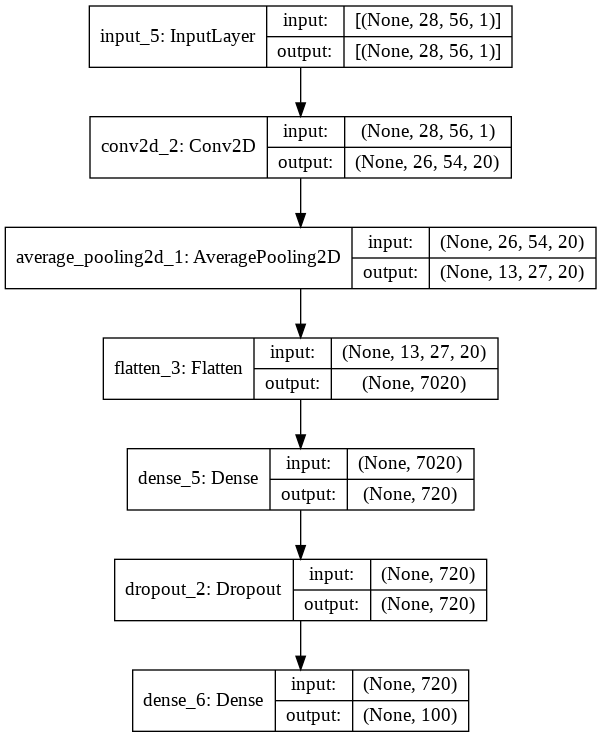

In [12]:
######## Plot model diagrams
#tf.keras.utils.plot_model(get_model[("ocNN","no")], 
#                          show_layer_names=True, 
#                          show_shapes=True, 
#                          to_file="diagram_ocNN.png")

tf.keras.utils.plot_model(get_model[("comboNN","no")], 
                          show_layer_names=True, 
                          show_shapes=True, 
                          to_file="diagram_comboNN.png")

In [13]:
############# Compile and Train all 20 models
stats = {}
for key in training_keys:    
    nc = key[1]
    model = get_model[key]
    compile_model(model)
    train_stats = train(model, train_data[nc], val_data[nc], epochs=epochs)
    stats.update({key:train_stats})

Compiled model miniNN_no
Epoch 1/10
200/200 [==============================] - 2s 4ms/step - loss: 2.7216 - acc: 0.4576 - val_loss: 1.1155 - val_acc: 0.7442
Epoch 2/10
200/200 [==============================] - 1s 3ms/step - loss: 1.0249 - acc: 0.7575 - val_loss: 0.8401 - val_acc: 0.7926
Epoch 3/10
200/200 [==============================] - 1s 3ms/step - loss: 0.8064 - acc: 0.7933 - val_loss: 0.7531 - val_acc: 0.8064
Epoch 4/10
200/200 [==============================] - 1s 3ms/step - loss: 0.7169 - acc: 0.8140 - val_loss: 0.7068 - val_acc: 0.8158
Epoch 5/10
200/200 [==============================] - 1s 3ms/step - loss: 0.6599 - acc: 0.8256 - val_loss: 0.6821 - val_acc: 0.8179
Epoch 6/10
200/200 [==============================] - 1s 3ms/step - loss: 0.6253 - acc: 0.8328 - val_loss: 0.6651 - val_acc: 0.8234
Epoch 7/10
200/200 [==============================] - 1s 3ms/step - loss: 0.6021 - acc: 0.8390 - val_loss: 0.6519 - val_acc: 0.8272
Epoch 8/10
200/200 [==============================]

#Evaluate the Results

### Training stats

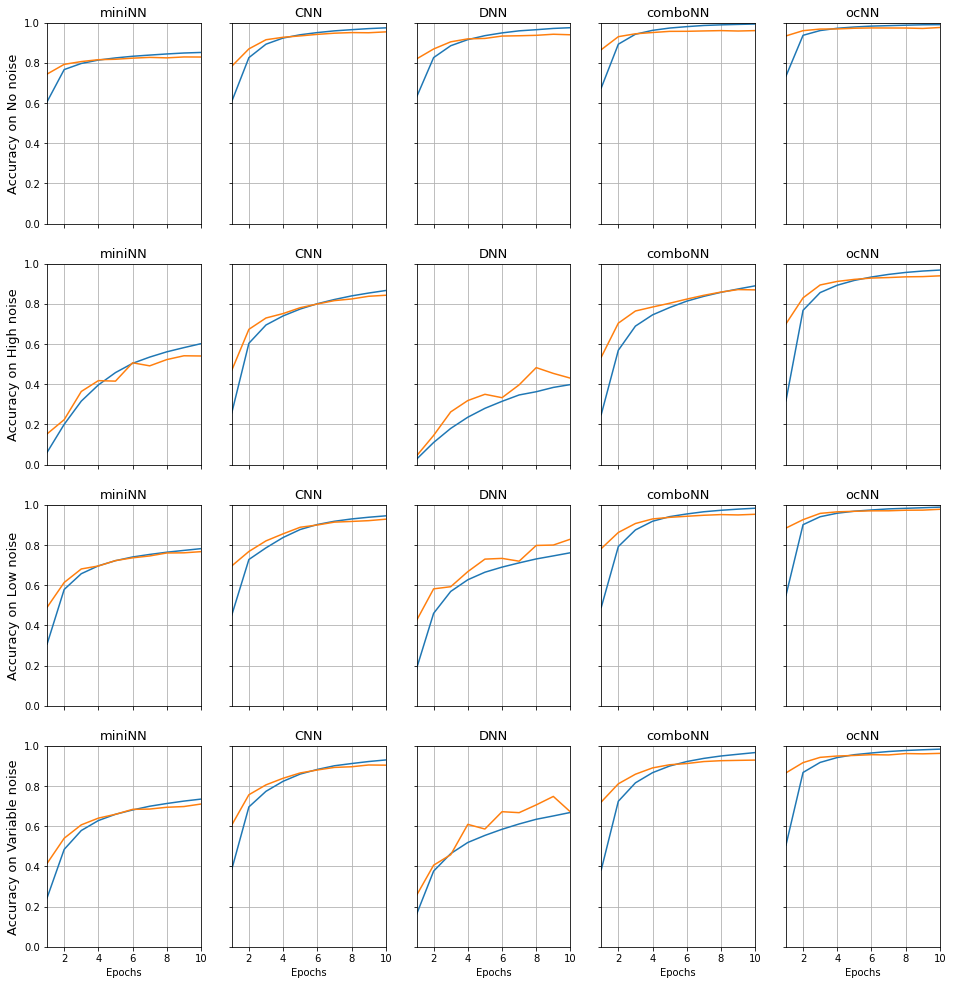

In [14]:
### Plot the learning curves for all 20 models during training
ncols = 5 #number of model types
nrows = 4 #number of noise conditions

fig = plt.figure(figsize=(16,17))
#fig.suptitle("Training accuracy by epoch for each model-type",
#             va='center',
#             fontsize=16)
#fig.set_tight_layout('pad')
axarr = fig.subplots(nrows,ncols,sharey=True,sharex=True,)
axarr = axarr.reshape((nrows*ncols,))

for i, tk in enumerate(training_keys):
    ax = axarr[i]
    if i%ncols==0: ax.set_ylabel("Accuracy on "+describe_nl[tk[1]], fontsize=13)
    if i>=15: ax.set_xlabel("Epochs")   
    ax.set_title(tk[0], fontsize=13)
    ax.set_xlim(1,epochs)
    ax.set_ylim(0,1)
    ax.set_yticks=[0.01]+[t/10 for t in range(1,10,2)]+[0.95]
    ax.grid(True)
    acc_line, = ax.plot(range(1,epochs+1),stats[tk]['acc'])
    val_line, = ax.plot(range(1,epochs+1),stats[tk]['val_acc'])

###Evaluation

In [15]:
### Collect and Display Evaluation results for all models and all noise levels
results = {}
for key in training_keys:
    model = get_model[key]
    print (">>>>>>>>>>>>>>> Key:", key)
    for nl in noise_levels:
        evalkey = (model.name, nl)
        x, y = test_data[nl]
        evaluated = model.evaluate(x=x, 
                                   y=y, 
                                   verbose=0, 
                                   batch_size=validation_batch_size)
        results.update({evalkey:round(evaluated[1], 4)})
        condition = describe_nl[nl]
        print(model.name,"tested on",condition,":",round(evaluated[1], 4))

>>>>>>>>>>>>>>> Key: ('miniNN', 'no')
miniNN_no tested on No noise : 0.8281
miniNN_no tested on High noise : 0.018
miniNN_no tested on Low noise : 0.1492
miniNN_no tested on Variable noise : 0.1794
>>>>>>>>>>>>>>> Key: ('CNN', 'no')
CNN_no tested on No noise : 0.9536
CNN_no tested on High noise : 0.1611
CNN_no tested on Low noise : 0.837
CNN_no tested on Variable noise : 0.5981
>>>>>>>>>>>>>>> Key: ('DNN', 'no')
DNN_no tested on No noise : 0.9413
DNN_no tested on High noise : 0.038
DNN_no tested on Low noise : 0.1898
DNN_no tested on Variable noise : 0.2287
>>>>>>>>>>>>>>> Key: ('comboNN', 'no')
comboNN_no tested on No noise : 0.9609
comboNN_no tested on High noise : 0.4945
comboNN_no tested on Low noise : 0.9429
comboNN_no tested on Variable noise : 0.8342
>>>>>>>>>>>>>>> Key: ('ocNN', 'no')
ocNN_no tested on No noise : 0.9765
ocNN_no tested on High noise : 0.382
ocNN_no tested on Low noise : 0.9346
ocNN_no tested on Variable noise : 0.785
>>>>>>>>>>>>>>> Key: ('miniNN', 'high')
miniN

In [16]:
### Build a DataFrame to hold the results of evaluation 
rows = len(training_keys)
results_df = pd.DataFrame(columns=["model"]+["trained_on"]+noise_levels, index=range(rows))
for row, (model_kind, train_condition) in enumerate(training_keys):
    results_df.iloc[row]["model"]=model_kind
    results_df.iloc[row]["trained_on"]=train_condition
    for test_condition in noise_levels:
        results_df.iloc[row][test_condition] = results[(model_kind+"_"+train_condition, test_condition)]
results_df.to_csv('results.csv')
results_df.sort_values(["model","trained_on"])

,model,trained_on,no,high,low,var
6,CNN,high,0.8985,0.8404,0.8952,0.8824
11,CNN,low,0.9287,0.7538,0.9273,0.8915
1,CNN,no,0.9536,0.1611,0.837,0.5981
16,CNN,var,0.9313,0.845,0.9277,0.9075
7,DNN,high,0.6698,0.4412,0.6269,0.5774
12,DNN,low,0.8199,0.5073,0.8338,0.7475
2,DNN,no,0.9413,0.038,0.1898,0.2287
17,DNN,var,0.8587,0.4172,0.7751,0.6765
8,comboNN,high,0.9266,0.8752,0.9252,0.914
13,comboNN,low,0.9588,0.6334,0.9524,0.8859


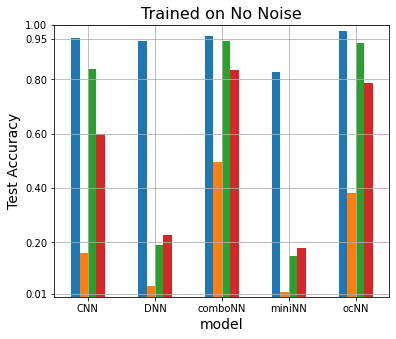

In [17]:
## Display baseline results for the no-noise training condition
f = plt.figure(figsize=(6,5))
condax = f.add_subplot(1,1,1)
condax.set_ylim(ymin=0,ymax=1.0)
condax.set_title("Trained on No Noise", fontsize=16)
condax.set_ylabel("Test Accuracy",fontsize=14)
condax.set_xlabel("Model",fontsize=14)
r_df = results_df.loc[lambda df: df["trained_on"]=="no"].sort_values('model')
r_df.plot(  x="model", 
            y=["no","high","low","var"], 
            kind='bar', 
            ax=condax,
            legend=False,
            grid=True,
            yticks=[0.01]+[t/10 for t in range(2,11,2)]+[0.95],
            )
ticks = plt.xticks(rotation=0)

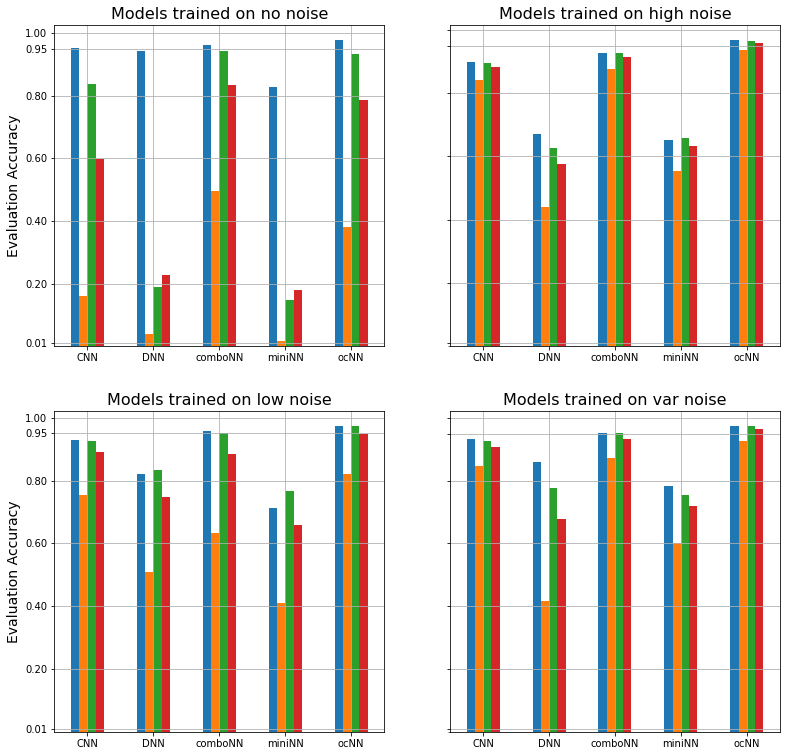

In [18]:
## Plot results for each training condition (noise level) ####
f = plt.figure(figsize=(13,13))
for i,nl in enumerate(noise_levels): 
    condax = f.add_subplot(2,2,i+1)
    condax.set_title("Models trained on "+nl+" noise", fontsize=16)
    condax.set_ylabel("Evaluation Accuracy", fontsize=14)
    r_df = results_df.loc[lambda df: df["trained_on"]==nl].sort_values('model')
    r_df.plot("model", 
              ["no","high","low","var"], 
              kind='bar', 
              ax=condax, 
              legend=False,
              grid=True,
              yticks=[0.01]+[t/10 for t in range(2,11,2)]+[0.95],
              sharey=True,
              xlabel=""
              )
    plt.xticks(rotation=0)

<Figure size 504x504 with 0 Axes>

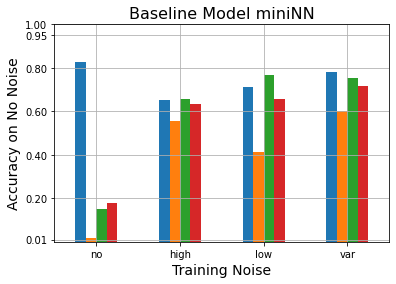

In [19]:
## Plot results for the baseline model ####
f = plt.figure(figsize=(7,7))
r_df = results_df.loc[lambda df: df["model"]=="miniNN"].sort_values('model')
plot = r_df.plot(   x="trained_on", 
                    y=["no","high","low","var"], 
                    kind='bar', 
                    yticks=[0.01]+[t/10 for t in range(2,11,2)]+[0.95],
                    sharey=True,
                    legend=False,
                    grid=True,
                    )
plt.title("Baseline Model miniNN",fontsize=16)
plt.ylabel("Accuracy on No Noise", fontsize=14)
plt.xlabel("Training Noise", fontsize=14)
lo, la = plt.xticks(rotation=0)

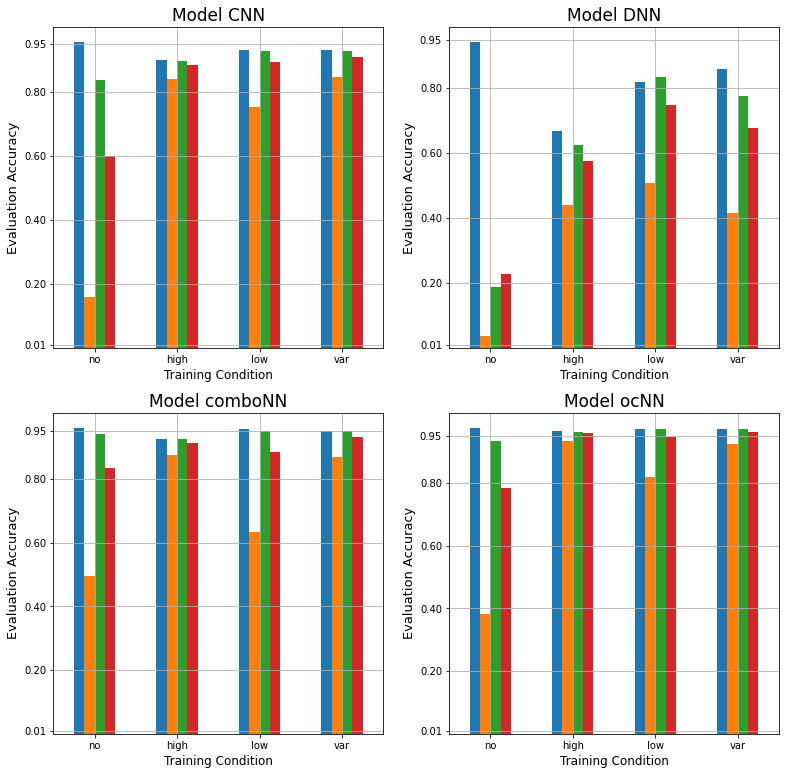

In [20]:
## Plot results for each model ####
f = plt.figure(figsize=(13,13))
mks = model_kinds.copy()
mks.remove("miniNN")
for i, m in enumerate(mks):
    condax = f.add_subplot(2,2,i+1)
    condax.set_title("Model "+m, fontsize=17)
    condax.set_ylabel("Evaluation Accuracy", fontsize=13)
    condax.set_xlabel("", fontsize=12)
    r_df = results_df.loc[lambda df: df["model"]==m].sort_values('model')
    r_df.plot(x="trained_on", 
              y=["no","high","low","var"], 
              kind='bar', 
              ax=condax,
              xlabel="Training Condition",
              yticks=[0.01]+[t/10 for t in range(2,10,2)]+[0.95],
              #sharey=True,
              legend=False,
              grid=True,
              )
    plt.xticks(rotation=0)